# Atividade 5
# Propagação de doenças:
# um estudo através de autômatos celulares

### Thaís Ferreira da Silva - 2021092571

In [453]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import jit

### Funções Auxiliares

In [454]:
#vizinhos = construção da tabela
@jit(nopython=True)
def calc_vizinhos(N):
    #Define a tabela de vizinhos
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0: viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1): viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0): viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L: viz[k,3] = k+N-L
    return viz

In [455]:
def plot_status(ax, sistema, numIter, seed):
    # Configurar o tamanho do sistema
    L = int(np.sqrt(sistema.size))
    x, y = np.meshgrid(np.arange(L), np.arange(L))

    # Plotar o scatter plot
    scatter = ax.scatter(x, y, s=200, c=sistema, cmap='jet', edgecolor='k', marker='o', alpha=0.75)

    # Adicionar título e configurações do eixo
    ax.set_title(f'Iteração nº {numIter} / Seed: {seed}', fontsize=10)
    ax.set_xlabel('X', fontsize=8)
    ax.set_ylabel('Y', fontsize=8)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Criar a legenda manualmente
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Suscetível'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Infectado'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Recuperado')
    ]

    # Adicionar a legenda no topo
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),  # Centralizar no topo
        ncol=3,  # Mostrar em uma linha
        fontsize=8,
        frameon=False  # Remover a borda da legenda
    )

    return scatter


In [456]:
def run_simulation(sistema, pAdoecer, pRecuperar, vizinhos, plotar, seed):
    # Definição de estados dos indivíduos
    SUSCEPTIBLE = 0  # Indivíduo suscetível
    INFECTED = 2     # Indivíduo infectado
    RECOVERED = 1    # Indivíduo recuperado

    # Inicialização de variáveis
    N = sistema.shape[0]
    qtdRecuperados = 0
    qtdNormais = N - 1
    qtdDoentes = 1

    # Histórico das populações em cada estado
    historicoRecuperados = [qtdRecuperados]
    historicoNormais = [qtdNormais]
    historicoDoentes = [qtdDoentes]

    numIter = 0  # Contador de iterações

    # Configuração dos subplots para gráficos
    num_plots = len(plotar)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    if num_plots == 1:  # Garantir que `axes` seja uma lista mesmo com um único plot
        axes = [axes]

    # Simulação principal
    while INFECTED in sistema:
        sistemaEmAnalise = np.copy(sistema)  # Copiar estado atual do sistema

        # Iterar sobre cada indivíduo
        for i in range(N):
            # Contar vizinhos infectados
            numVizinhosInfectados = sum(sistemaEmAnalise[vizinhos[i, :]] == INFECTED)

            # Regras de transição
            if sistemaEmAnalise[i] == SUSCEPTIBLE:  # Indivíduo suscetível
                for _ in range(numVizinhosInfectados):
                    if np.random.random() < pAdoecer:
                        sistema[i] = INFECTED
                        qtdNormais -= 1
                        qtdDoentes += 1
                        break

            elif sistemaEmAnalise[i] == INFECTED:  # Indivíduo infectado
                if np.random.random() < pRecuperar:
                    sistema[i] = RECOVERED
                    qtdDoentes -= 1
                    qtdRecuperados += 1

        # Plotar o sistema no momento especificado
        if numIter in plotar:
            idx = plotar.index(numIter)
            plot_status(axes[idx], sistema, numIter, seed)

        # Atualizar contadores e históricos
        numIter += 1
        historicoRecuperados.append(qtdRecuperados)
        historicoNormais.append(qtdNormais)
        historicoDoentes.append(qtdDoentes)

    # Ajustar layout dos subplots e exibir gráficos
    plt.tight_layout()
    plt.show()

    # Retornar número de iterações e históricos de estados
    return numIter, historicoRecuperados, historicoNormais, historicoDoentes


In [457]:
def monte_carlo(L, pAdoecer, pRecuperar, plotar, seed):
    N = L**2
    sistema = np.zeros(N)
    sistema[np.random.randint(N)] = 2
    vizinhos = calc_vizinhos(N)
    return run_simulation(sistema, pAdoecer, pRecuperar, vizinhos, plotar, seed)


In [458]:
def modelo_sir(L, prob_infectar, prob_recuperar, seed, plot=[0, 15, 30]):
    # Configurar a semente para reprodutibilidade
    if seed is None:
        seed = random.randint(0, 10000)

    # Executar a simulação Monte Carlo com a semente fornecida
    resultado = monte_carlo(L, prob_infectar, prob_recuperar, plot, seed)
    
    # Extrair os dados de cada estado da simulação
    recuperados = np.asarray(resultado[1])  # Número de indivíduos recuperados ao longo do tempo
    normais = np.asarray(resultado[2])      # Número de indivíduos suscetíveis ao longo do tempo
    doentes = np.asarray(resultado[3])      # Número de indivíduos infectados ao longo do tempo
    
    # Gerar o eixo x (tempo)
    tempo = np.arange(len(recuperados))
    
    # Criar o gráfico dos resultados
    plt.figure(figsize=(12, 4))
    
    # Plotar o número de recuperados
    plt.plot(
        tempo, recuperados, 
        label='Recuperados', color='green', linestyle='-', marker='o', markersize=5
    )
    
    # Plotar o número de indivíduos normais (suscetíveis)
    plt.plot(
        tempo, normais, 
        label='Normais', color='blue', linestyle='--', marker='s', markersize=5
    )
    
    # Plotar o número de doentes (infectados)
    plt.plot(
        tempo, doentes, 
        label='Doentes', color='red', linestyle='-', marker='^', markersize=5
    )
    
    # Configurações do gráfico
    plt.title('Modelo Epidemiológico SIR ao Longo do Tempo', fontsize=14)
    plt.xlabel('Tempo', fontsize=12)
    plt.ylabel('Número de Indivíduos', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()


In [459]:
SEED = random.randint(0, 10000)

# MELHOR SEED ENCONTRADA 7377

### Experimentos

#### 1. Alta taxa de contaminação e baixa recuperação

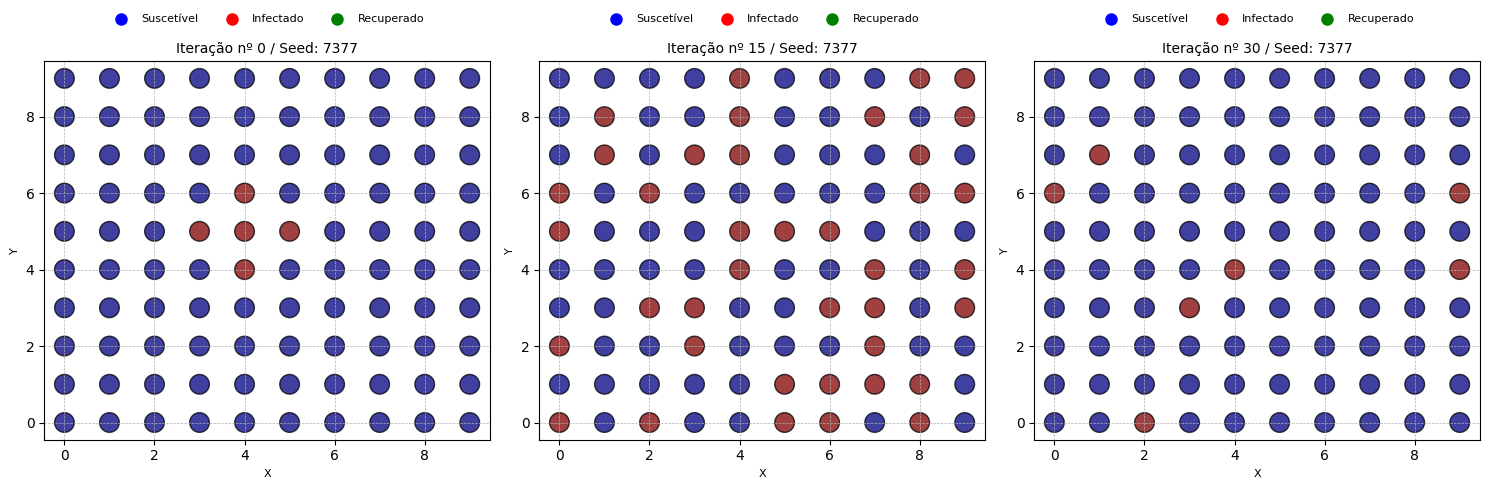

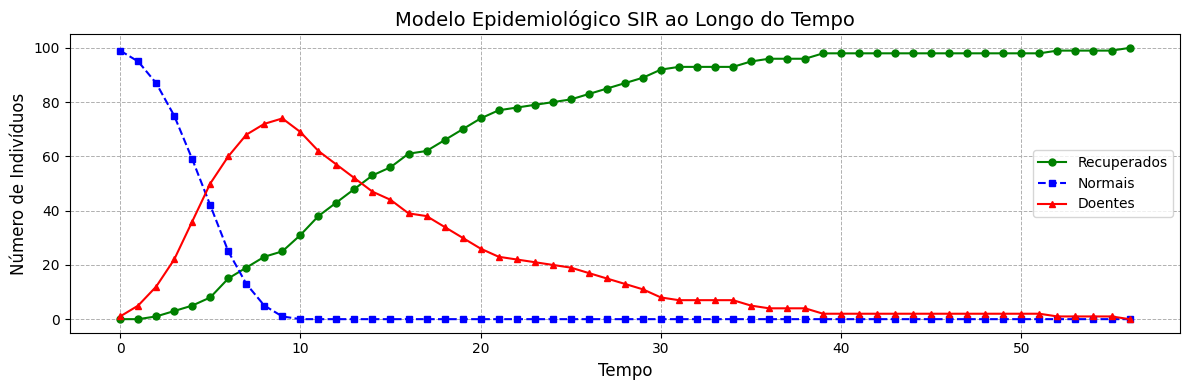

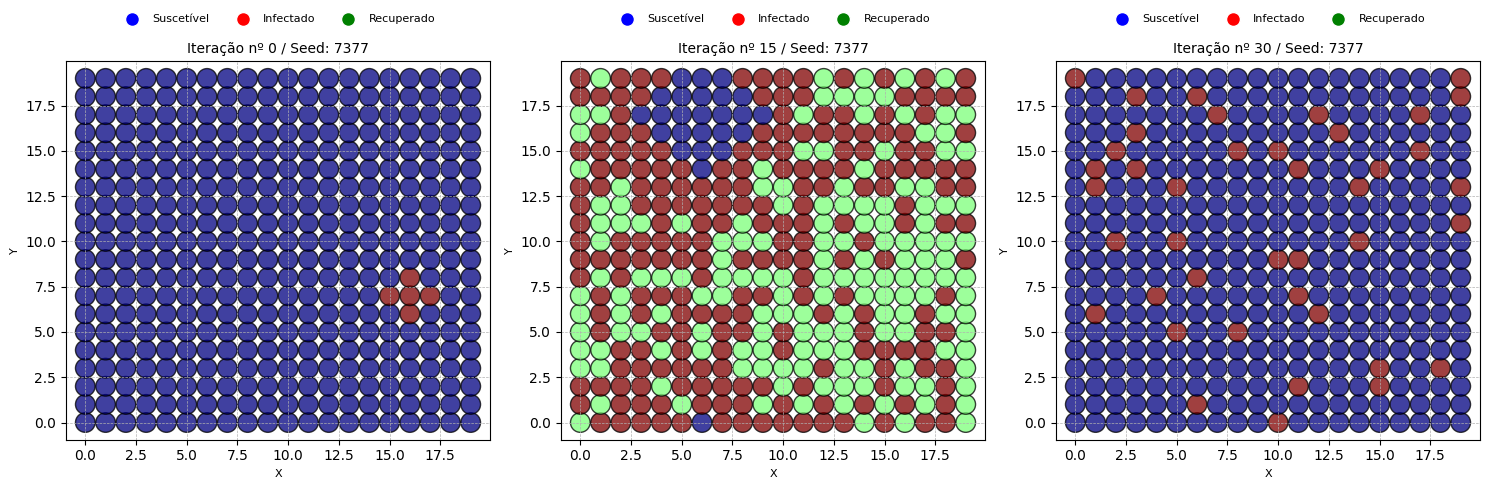

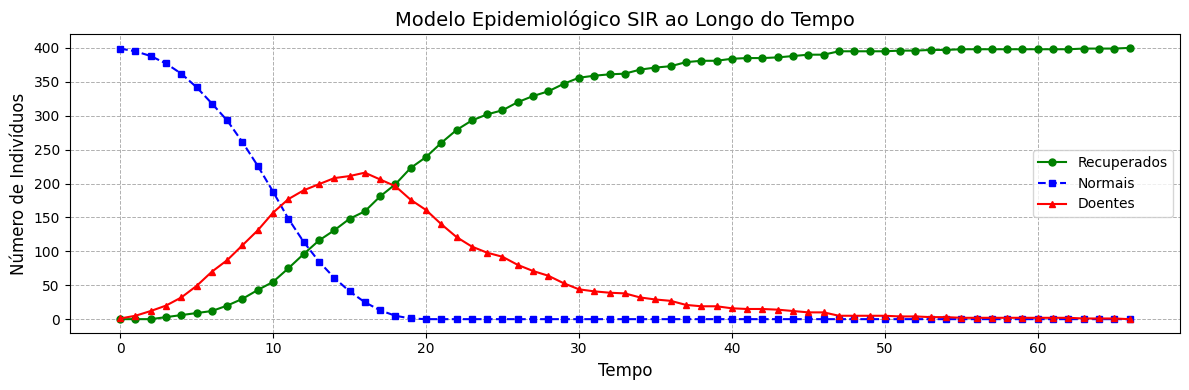

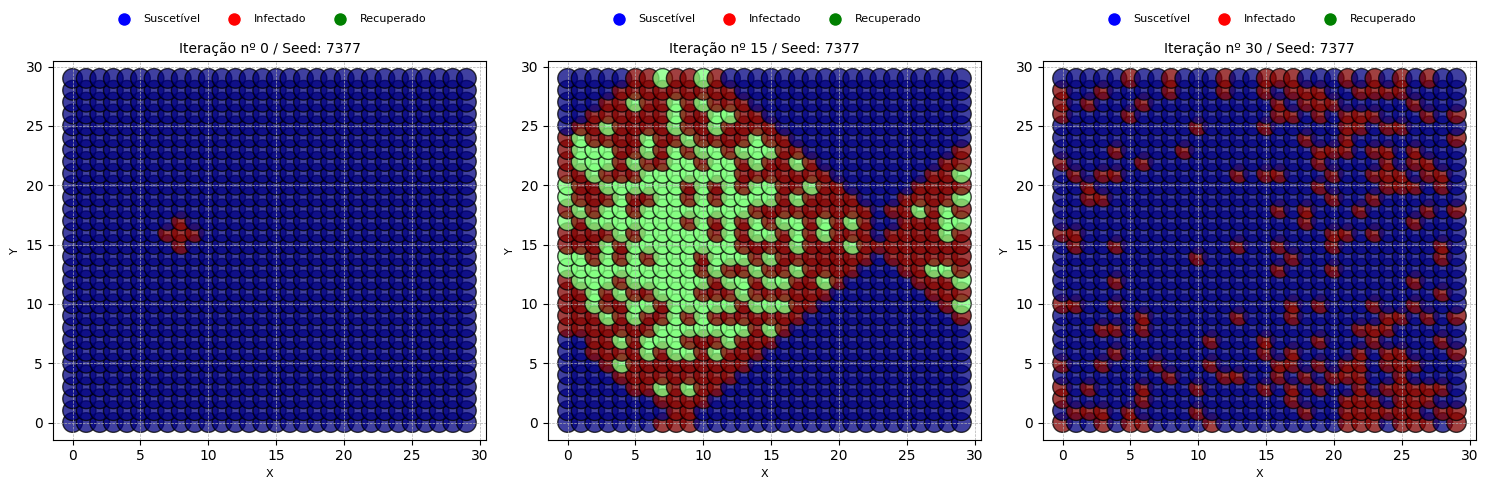

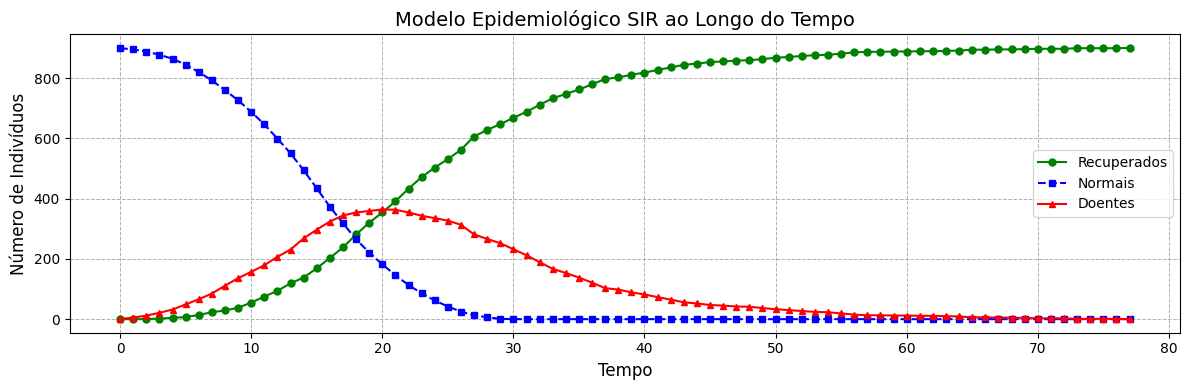

In [460]:
#Total de indivíduos, probabilidade de adoecer, probabilidade de recuperar
# Experimento -> Alta taxa de contaminação e baixa recuperação
modelo_sir(10, 0.9, 0.1, SEED)
modelo_sir(20, 0.9, 0.1, SEED)
modelo_sir(30, 0.9, 0.1, SEED)

Atraves desse experimento podemos perceber que nos casos de alta taxa de contaminação e baixa recuperação temos um rápido pico de contaminação (bem no início do grafico) e uma lenta recuperção dos contaminados (longo periodo até que toda a população esteja bem novamente). 

Ao aumentar o tamanho da população, percebemos o prolongamento do tempo até a cura total da população.

#### 2. Taxas médias de contaminação e recuperação

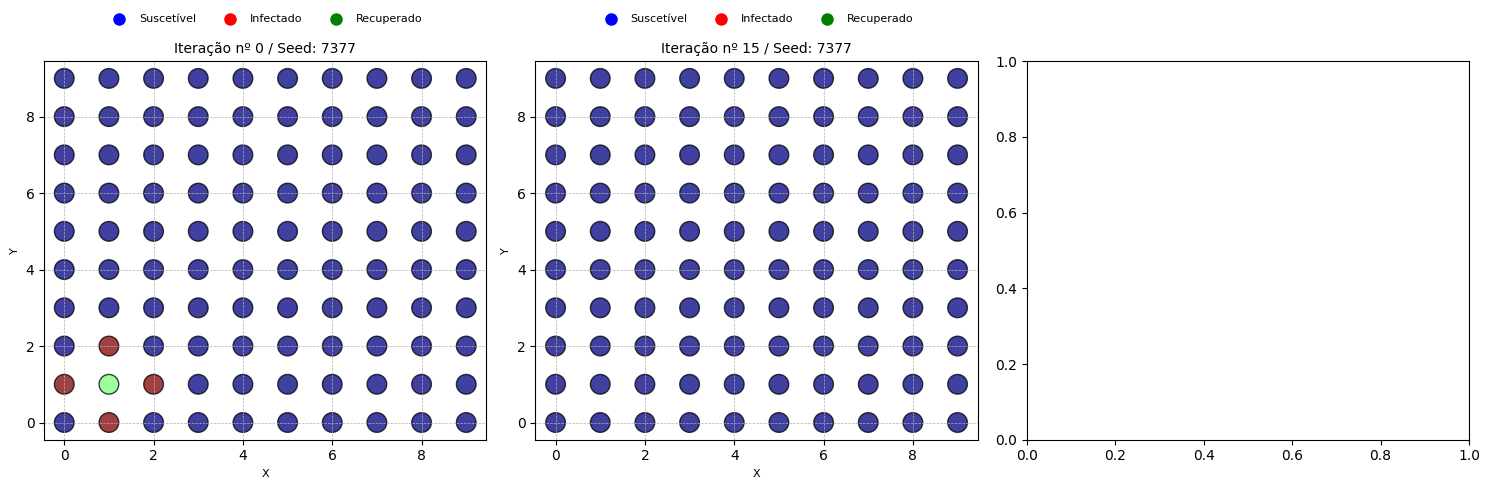

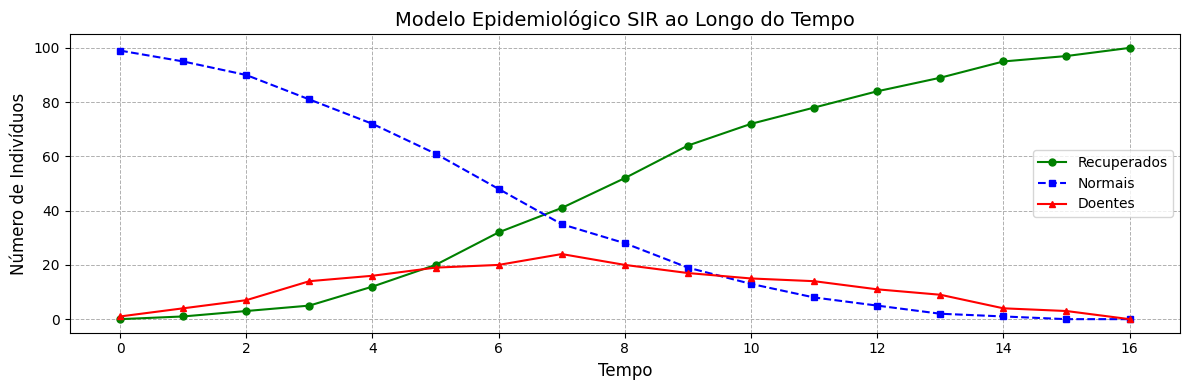

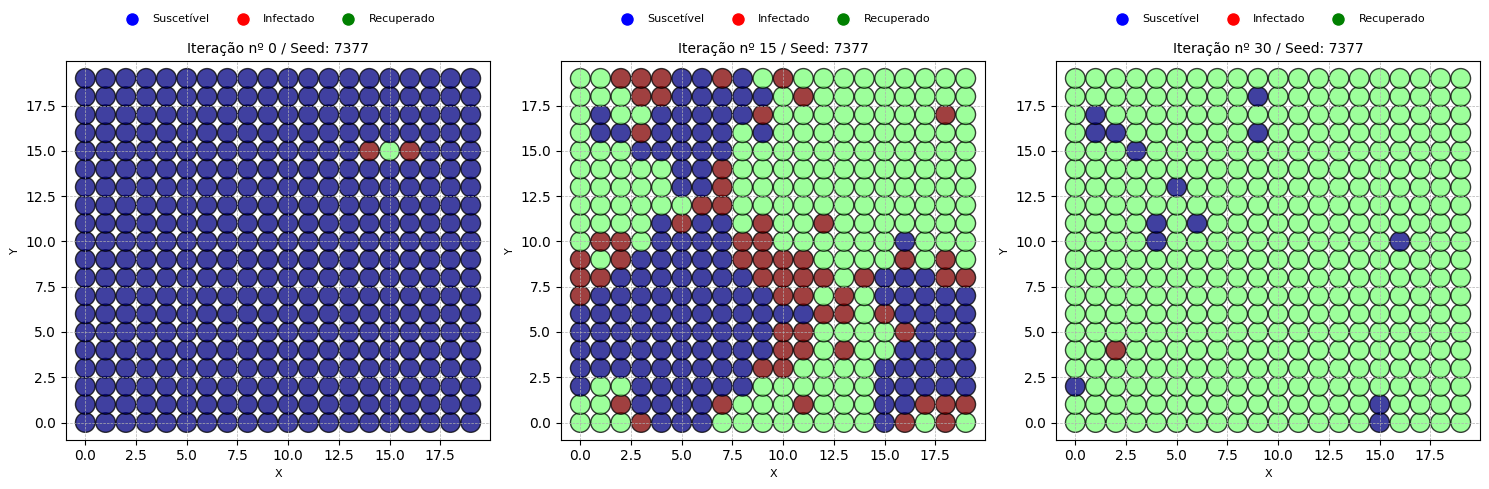

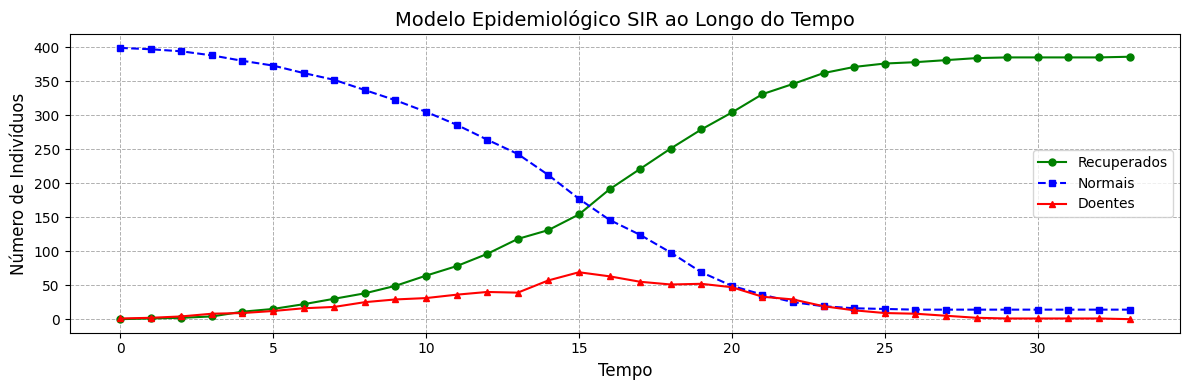

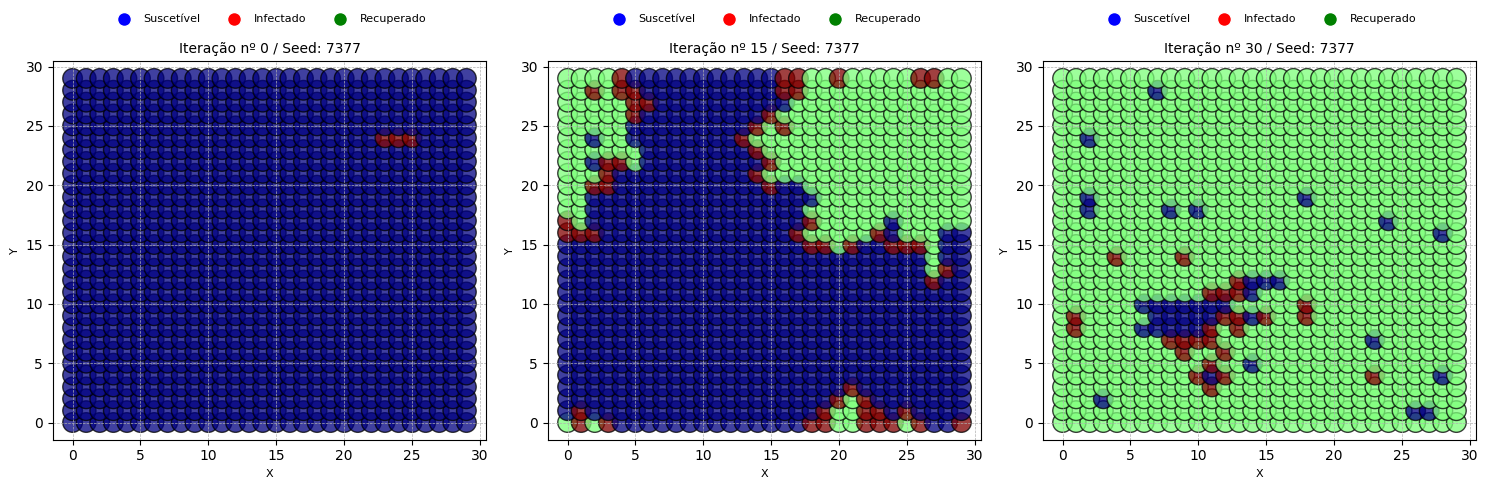

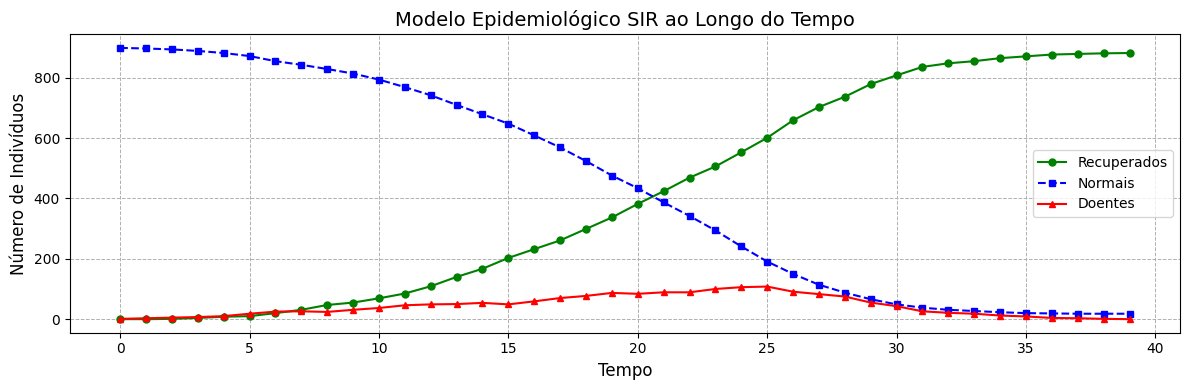

In [461]:
#Experimento -> Taxas médias de contaminação e recuperação
modelo_sir(10, 0.5, 0.5, SEED)
modelo_sir(20, 0.5, 0.5, SEED)
modelo_sir(30, 0.5, 0.5, SEED)

Atraves desse experimento podemos perceber que nos casos de taxas médias de contaminação e recuperação temos um pequeno pico de contaminação central (bem no centro do grafico) e uma recuperção dos contaminados também em uma velocidade ok (também ao centro do grafico). 

Ao aumentar o tamanho da população, percebemos o prolongamento do tempo até a cura total da população.
E se comparado com o primeiro experimento, vemos uma redução do tempo necessário para a cura total da população (reduzimos o tempo por mais que a metade)

#### 3. Baixa taxa de contaminação e baixa recuperação

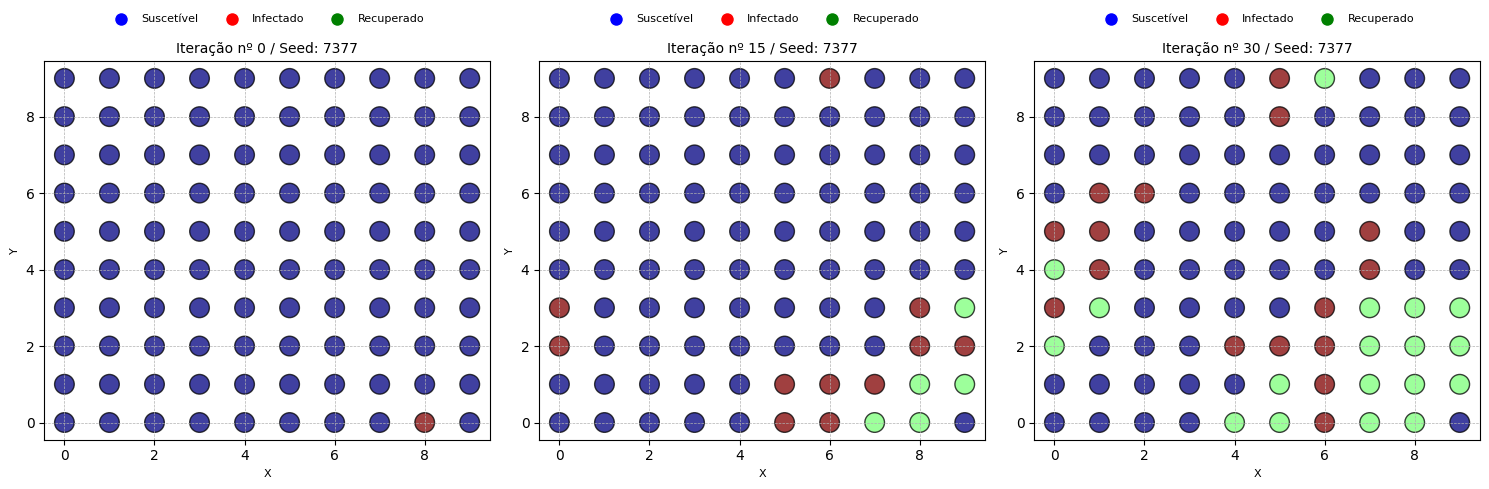

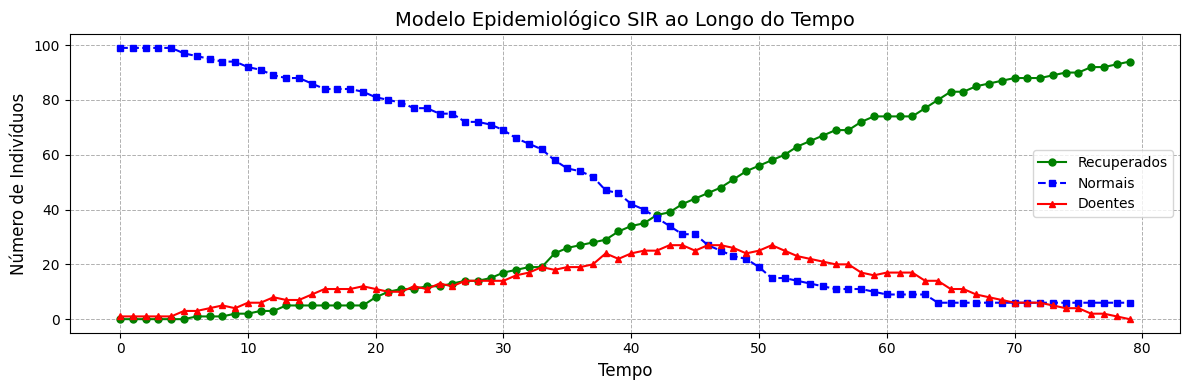

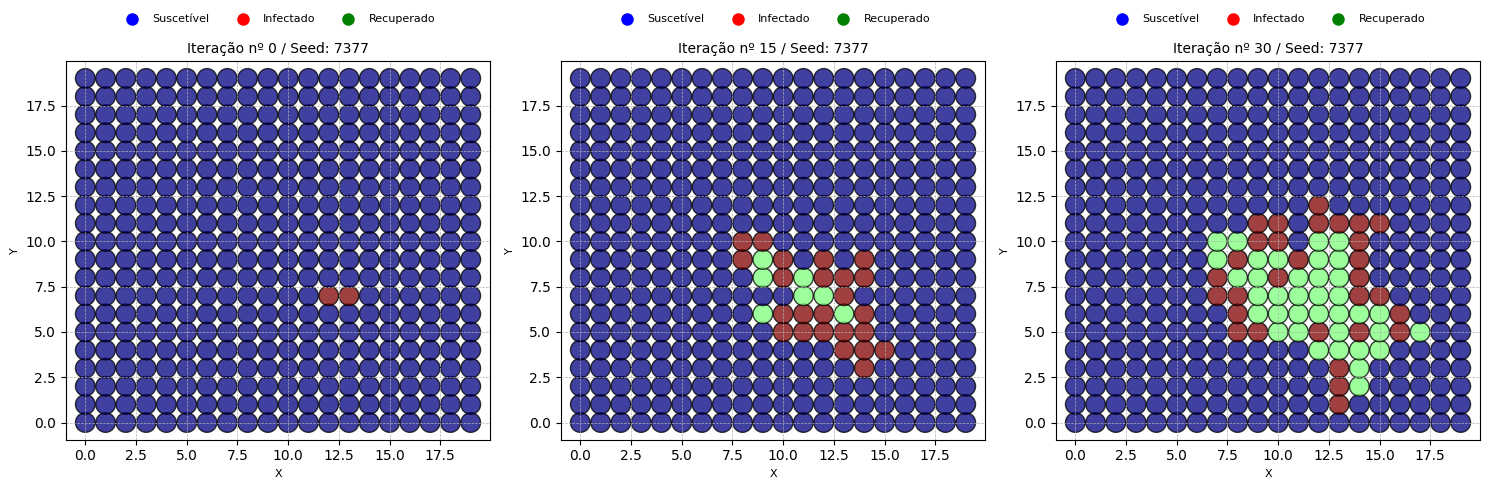

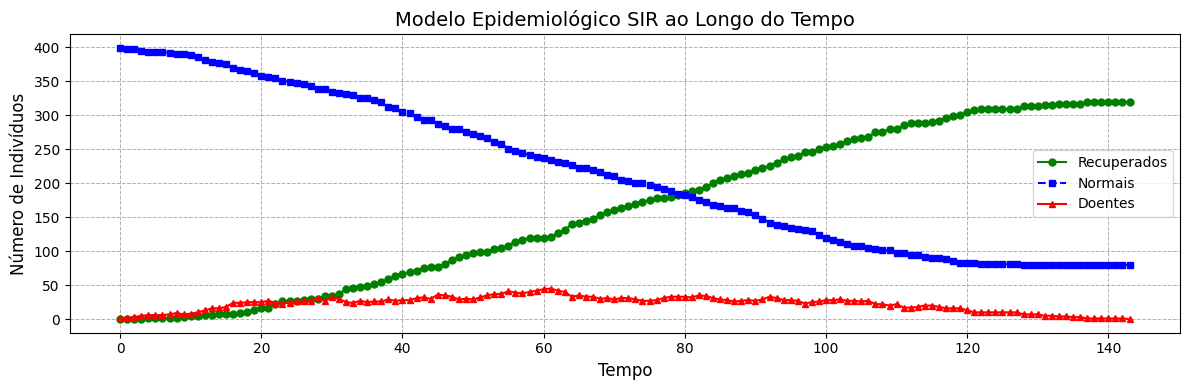

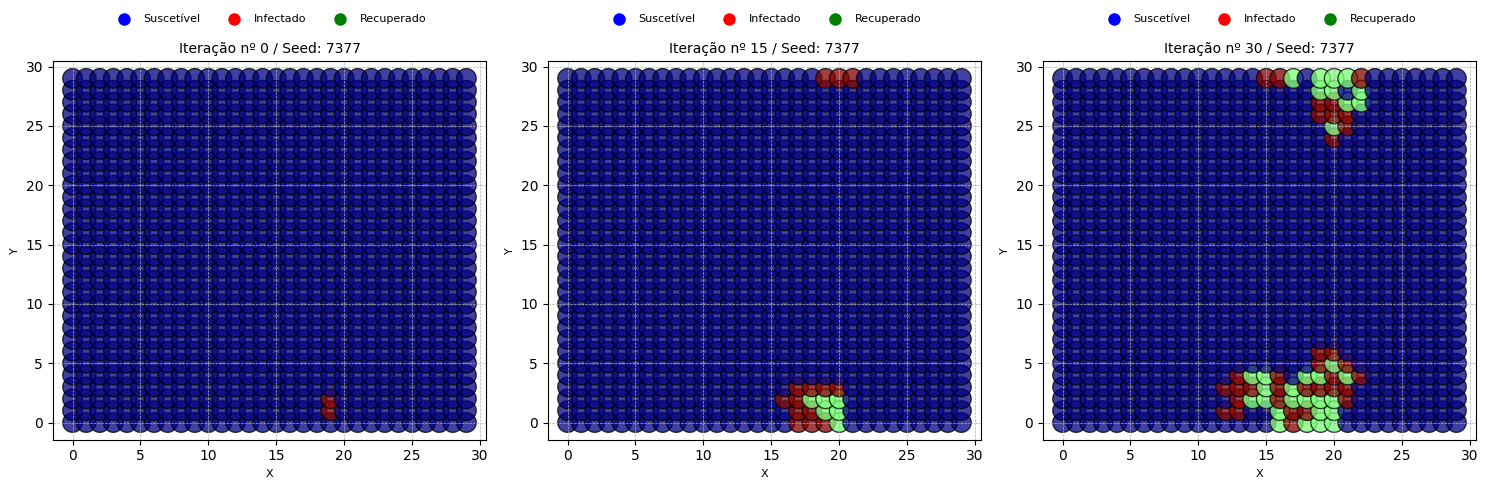

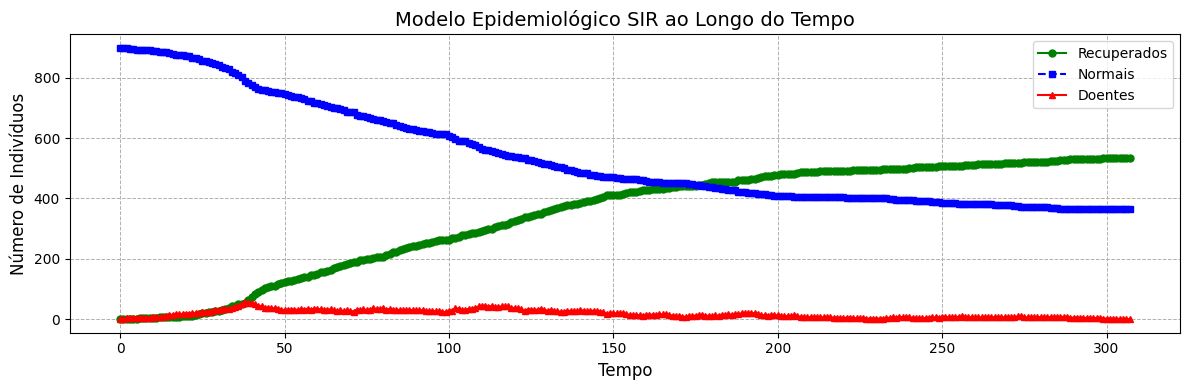

In [462]:
#Experimento -> Baixa taxa de contaminação e baixa recuperação
modelo_sir(10, 0.1, 0.1, SEED)
modelo_sir(20, 0.1, 0.1, SEED)
modelo_sir(30, 0.1, 0.1, SEED)

Atraves desse experimento podemos perceber que nos casos de baixa taxa de contaminação e baixa recuperação temos vários mini picos locais de contaminação (distribuidos ao longo de todo o periodo) e uma recuperção quase que linear (possui pequenas variações, mas seu comportamente lembra uma linha para populações maiores). 

Ao aumentar o tamanho da população, percebemos o prolongamento do tempo até a cura total da população, e também vemos um deslocamento da troca das curvas de normais e recuperadas para o final do gráfico.

Se comparado com o primeiro experimento, vemos um aumento do tempo necessário para a cura total da população (aumentamos o tempo por mais que o dobro) mas em contrapartida a contaminação é bem mais lenta. E se comparado com o segundo experimento, temos um grafico parecido, mas em um periodo maior.

#### 4. Contaminação fixa e recuperação variável

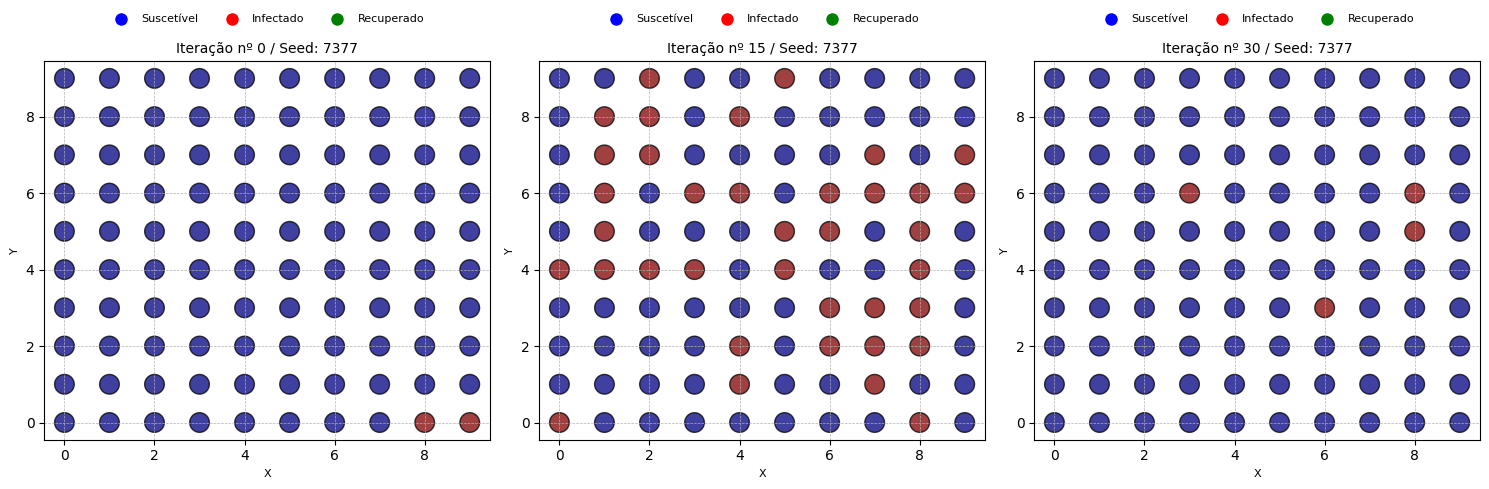

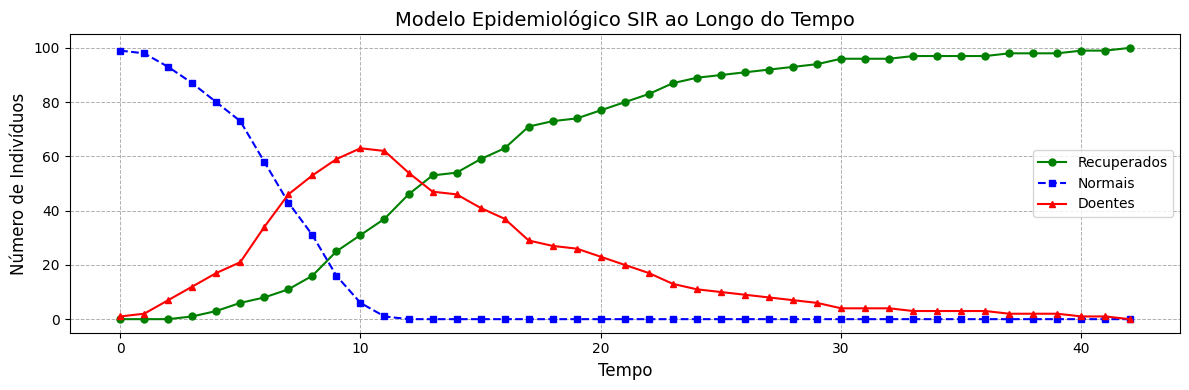

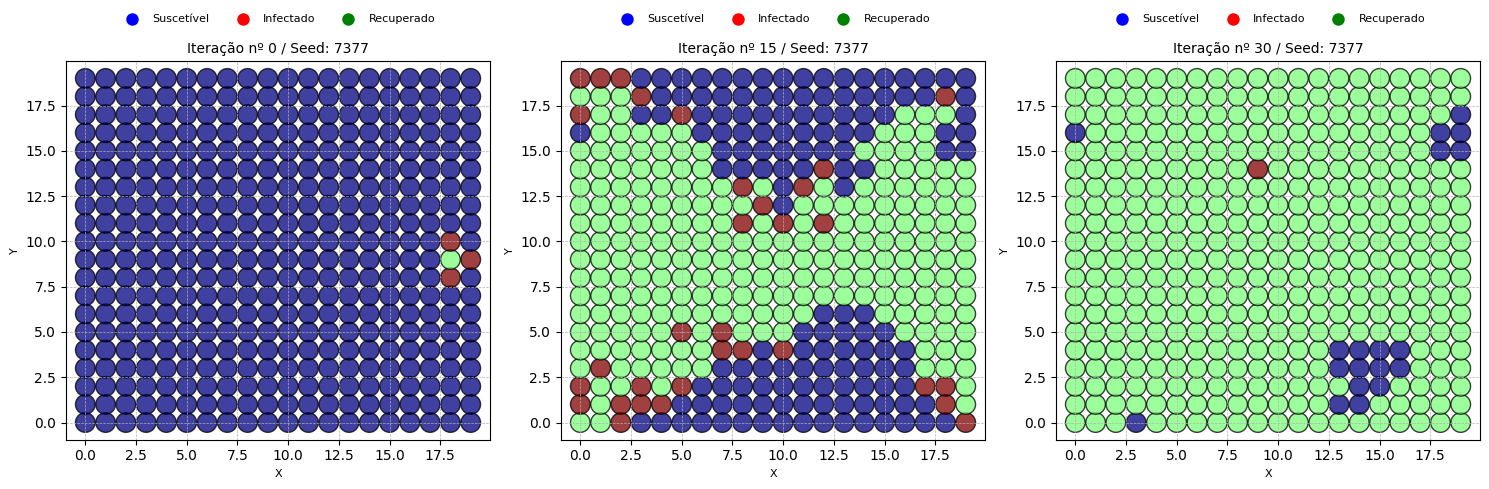

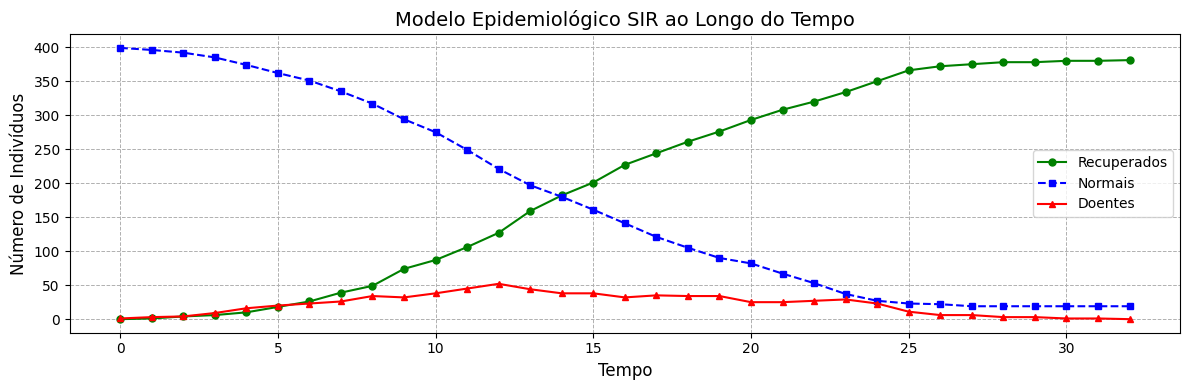

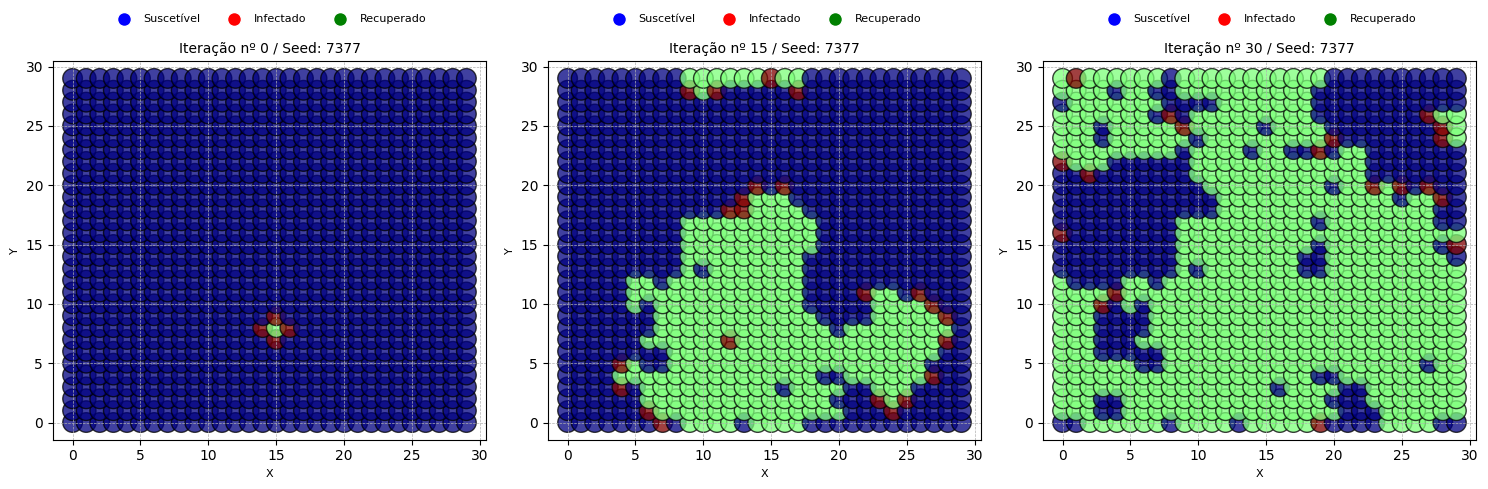

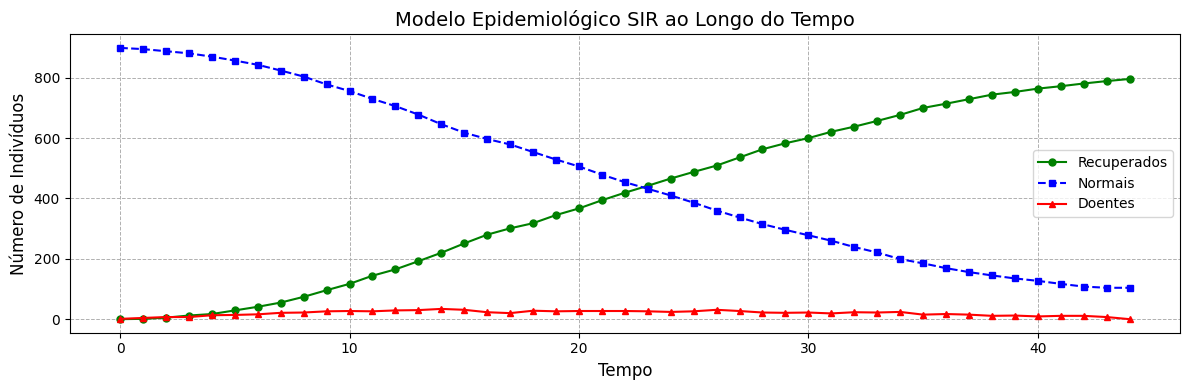

In [463]:
modelo_sir(10, 0.5, 0.1, SEED)
modelo_sir(20, 0.5, 0.5, SEED)
modelo_sir(30, 0.5, 0.9, SEED)

### Conclusão

Os experimentos realizados no estudo sobre propagação de doenças com o modelo SIR e autômatos celulares mostraram que as taxas de contaminação e recuperação afetam diretamente a dinâmica da epidemia. Com alta taxa de contaminação e baixa recuperação, houve um rápido pico de infecções seguido por uma recuperação lenta, e o aumento da população prolongou o tempo até a recuperação completa. Já com taxas médias, observou-se um pico central de infecções e recuperação moderada, sendo que populações maiores aumentaram o tempo de recuperação, mas de maneira menos significativa.

Em cenários de baixa taxa de contaminação e recuperação, a infecção se espalhou de forma dispersa, com picos menores ao longo do tempo, e a recuperação foi quase linear. A recuperação mais rápida, com contaminação fixa, resultou em um tempo total de erradicação da infecção reduzido. De forma geral, as populações maiores aumentaram a duração da epidemia, evidenciando como as taxas de contágio e recuperação influenciam a propagação das doenças no modelo SIR.